In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
from functools import partial

In [2]:
R = 1.0
F0 = 1.0

In [3]:
#df
class NN_df(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        df_out = self.layer_out(out)
        return df_out


In [4]:
class NN_f(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.ReLU()):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        f_out = self.layer_out(out)
        return f_out


In [5]:
from scipy.optimize import differential_evolution
def df(nn: NN_df, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)

def f(nn: NN_f, x: torch.Tensor, df_nn: NN_df) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    df_ = df(df_nn,x)
    df_previous = torch.zeros(df_.shape)
    df_previous[1:] = df_[0:-1] 
    df_extened = (torch.cat((df_previous, df_), 1))
    return nn(df_extened)
 
def compute_loss_df(
    nn: NN_df, x: torch.Tensor = None, verbose: bool = False
) -> torch.float: 
    interior_loss = df(nn, x) - R * x * (1 - x)
    # y = x-1
    # y[y<0] = 0
    # interior_loss_2 = df(nn, y) - R * y * (1-y) #mask = 0 
    ic = torch.Tensor([0.0])
    ic.requires_grad = True
    ic_weight = 0.1
    # ic_loss = f(nn, ic) - F0
    # ic_loss = f(nn, ic) - F0  
    de_loss = interior_loss.pow(2).mean() 
    # ic_loss = ic_weight*(ic_loss ** 2)
    final_loss = de_loss #+ ic_loss
    return final_loss

def f_truth(x: torch.Tensor = None) -> torch.Tensor:
    df_truth = R * x * (1 - x)
    f_truth = torch.ones(x.shape[0], 1)
    f_truth[0]= F0 + df_truth[0]
    for i in range(1, x.shape[0]):
        f_truth[i] = f_truth[i-1] +  df_truth[i]
    return f_truth 

def compute_loss_f(
    nn: NN_f, x: torch.Tensor = None, nn_df_trained: torch.Tensor = None, verbose: bool = False
) -> torch.float:

    f_train = f_truth(x)
    criterion = torch.nn.MSELoss()
    mse_loss = criterion(f(nn, x, nn_df_trained), f_train) 
    final_loss = mse_loss 
    # print(f"df_truth: \n {df_truth} df_train_extened: \n {df_train_extened} f_train: \n {f_train} \n f_predict: \n {f(nn, df_train_extened)} \n")
    return final_loss
 
def train_model_df(
    nn: NN_df,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NN_df:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)

def train_model_f(
    nn: NN_f,
    loss_fn: Callable, 
    learning_rate: int = 0.1,
    max_epochs: int = 2000,
) -> NN_f:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:
            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")
            # if epoch == 10: break 
            if epoch % 50 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


# def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

#     eps = 1e-4
#     dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
#     dfdx_sample = df(nn, x, order=1)

#     return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)


In [7]:
def run_model(lr=0.1, m_epochs=20_000):
    domain = [0.0, 1.0]
    x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
    x = x.reshape(x.shape[0], 1)

    nn_df = NN_df(4, 10)
    nn_f = NN_f(3, 10)
    # assert check_gradient(nn_approximator, x)

    # f_initial = f(nn_approximator, x)
    # ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")
 
    loss_fn = partial(compute_loss_df, x=x, verbose=True)
    
    nn_df_trained, loss_evolution = train_model_df(
        nn_df, loss_fn=loss_fn, learning_rate=lr, max_epochs=m_epochs
    )  
    loss_fn_f = partial(compute_loss_f, x=x, nn_df_trained = nn_df_trained, verbose=True)
    
    print(df(nn_df_trained, x))
    nn_f_trained, loss_evolution_f = train_model_f(
        nn_f, loss_fn=loss_fn_f, learning_rate=0.1,  max_epochs=2000
    )

    x_eval = torch.linspace(domain[0], domain[1], steps=15).reshape(-1, 1)

    # numeric solution
    def logistic_eq_fn(x, y):
        return R * x * (1 - x)

    numeric_solution = solve_ivp(
        logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
    )

    # plotting
    fig, ax = plt.subplots()

    f_truth_train = f_truth(x)
    f_truth_eval = f_truth(x_eval)
    f_final_training = f(nn_f_trained, x, nn_df_trained)
    f_final = f(nn_f_trained, x_eval, nn_df_trained)

    ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points (Predicted)", color="red")
    ax.scatter(x.detach().numpy(), f_truth_train.detach().numpy(), label="Training points (Actual)", color="blue")
    # ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution (Predicted)", color="black")
    # ax.scatter(x_eval.detach().numpy(), f_truth_eval.detach().numpy(), label="NN final solution (Actual)", color="cyan")
    # ax.plot(
    #     x_eval.detach().numpy(),
    #     numeric_solution.y.T,
    #     label=f"Analytic solution",
    #     color="green",
    #     alpha=0.75,
    # )
    ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
    ax.legend()

    fig, ax = plt.subplots()
    # print(loss_evolution.shape)
    ax.semilogy(loss_evolution.reshape(-1,1))
    ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
    ax.legend()

    plt.show()

Epoch: 0 - Loss: 0.010142
Epoch: 1000 - Loss: 0.007889
Epoch: 2000 - Loss: 0.007337
Epoch: 3000 - Loss: 0.004685
Epoch: 4000 - Loss: 0.000126
Epoch: 5000 - Loss: 0.000019
Epoch: 6000 - Loss: 0.000035
Epoch: 7000 - Loss: 0.000014
Epoch: 8000 - Loss: 0.000013
Epoch: 9000 - Loss: 0.000014
tensor([[0.0034],
        [0.0971],
        [0.1729],
        [0.2254],
        [0.2516],
        [0.2507],
        [0.2232],
        [0.1708],
        [0.0967],
        [0.0062]], grad_fn=<AddmmBackward0>)
Epoch: 0 - Loss: 2.511804
Epoch: 50 - Loss: 0.289971
Epoch: 100 - Loss: 0.272955
Epoch: 150 - Loss: 0.230067
Epoch: 200 - Loss: 0.171170
Epoch: 250 - Loss: 0.208756
Epoch: 300 - Loss: 0.180404
Epoch: 350 - Loss: 0.156116
Epoch: 400 - Loss: 0.130844
Epoch: 450 - Loss: 0.088057
Epoch: 500 - Loss: 0.088699
Epoch: 550 - Loss: 0.076126
Epoch: 600 - Loss: 0.028450
Epoch: 650 - Loss: 0.036037
Epoch: 700 - Loss: 0.065052
Epoch: 750 - Loss: 0.040935
Epoch: 800 - Loss: 0.008237
Epoch: 850 - Loss: 0.014480
Epoch

Epoch: 1950 - Loss: 0.001184


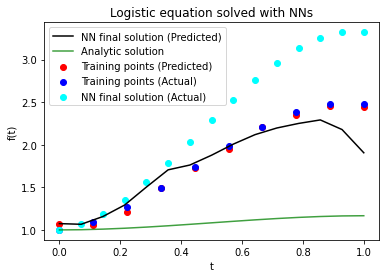

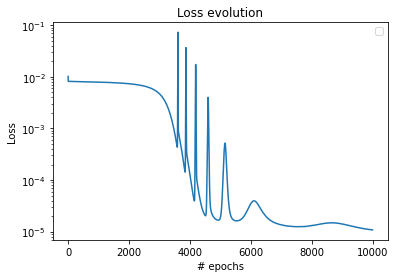

In [ ]:
#df
run_model(lr=0.1, m_epochs=10_000)

Epoch: 0 - Loss: 0.130862
Epoch: 1000 - Loss: 0.007319
Epoch: 2000 - Loss: 0.004599
Epoch: 3000 - Loss: 0.000200
Epoch: 4000 - Loss: 0.000060
Epoch: 5000 - Loss: 0.000037
Epoch: 6000 - Loss: 0.000036
Epoch: 7000 - Loss: 0.000019
Epoch: 8000 - Loss: 0.000016
Epoch: 9000 - Loss: 0.000013
tensor([[0.0030],
        [0.0958],
        [0.1716],
        [0.2245],
        [0.2510],
        [0.2501],
        [0.2223],
        [0.1696],
        [0.0956],
        [0.0058]], grad_fn=<AddmmBackward0>)
Epoch: 0 - Loss: 3.494287
Epoch: 50 - Loss: 0.272753
Epoch: 100 - Loss: 0.256691
Epoch: 150 - Loss: 0.235183
Epoch: 200 - Loss: 0.211927
Epoch: 250 - Loss: 0.186108
Epoch: 300 - Loss: 0.244268
Epoch: 350 - Loss: 0.251546
Epoch: 400 - Loss: 0.190186
Epoch: 450 - Loss: 0.181865
Epoch: 500 - Loss: 0.165278
Epoch: 550 - Loss: 0.145189
Epoch: 600 - Loss: 0.138442
Epoch: 650 - Loss: 0.079500
Epoch: 700 - Loss: 0.146407
Epoch: 750 - Loss: 0.019256
Epoch: 800 - Loss: 0.028733
Epoch: 850 - Loss: 0.006250
Epoch

Epoch: 1950 - Loss: 0.001548


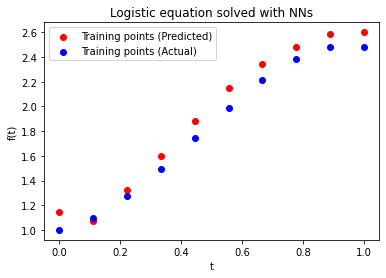

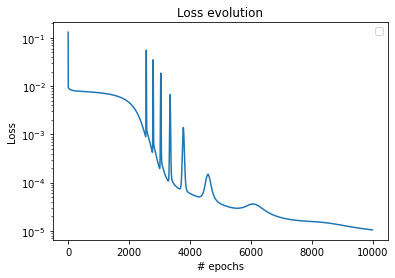

In [8]:
#df
run_model(lr=0.1, m_epochs=10_000)

Epoch: 0 - Loss: 0.077321
Epoch: 1000 - Loss: 0.007192
Epoch: 2000 - Loss: 0.002530
Epoch: 3000 - Loss: 0.000037
Epoch: 4000 - Loss: 0.000021
Epoch: 5000 - Loss: 0.000028
Epoch: 6000 - Loss: 0.000037
Epoch: 7000 - Loss: 0.000027
Epoch: 8000 - Loss: 0.000023
Epoch: 9000 - Loss: 0.000022
tensor([[0.0011],
        [0.0919],
        [0.1665],
        [0.2194],
        [0.2471],
        [0.2474],
        [0.2199],
        [0.1663],
        [0.0911],
        [0.0011]], grad_fn=<AddmmBackward0>)
Epoch: 0 - Loss: 2.557958
Epoch: 50 - Loss: 0.292752
Epoch: 100 - Loss: 0.286691
Epoch: 150 - Loss: 0.276796
Epoch: 200 - Loss: 0.258423
Epoch: 250 - Loss: 0.225287
Epoch: 300 - Loss: 0.261869
Epoch: 350 - Loss: 0.169588
Epoch: 400 - Loss: 0.443789
Epoch: 450 - Loss: 0.218082
Epoch: 500 - Loss: 0.153934
Epoch: 550 - Loss: 0.080591
Epoch: 600 - Loss: 0.059700
Epoch: 650 - Loss: 0.063008
Epoch: 700 - Loss: 0.033188
Epoch: 750 - Loss: 0.026182
Epoch: 800 - Loss: 0.073292
Epoch: 850 - Loss: 0.038913
Epoch

Epoch: 1950 - Loss: 0.000580


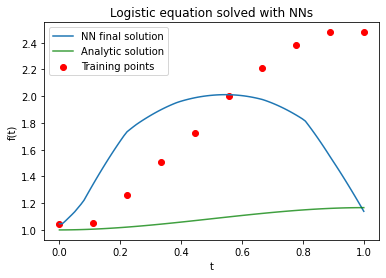

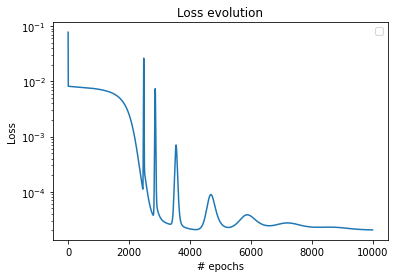

In [ ]:
#df
run_model(lr=0.1, m_epochs=10_000)

Epoch: 0 - Loss: 0.103075
Epoch: 1000 - Loss: 0.007512
Epoch: 2000 - Loss: 0.006308
Epoch: 3000 - Loss: 0.021839
Epoch: 4000 - Loss: 0.000093
Epoch: 5000 - Loss: 0.000126
Epoch: 6000 - Loss: 0.000038
Epoch: 7000 - Loss: 0.000027
Epoch: 8000 - Loss: 0.000019
Epoch: 9000 - Loss: 0.000014


df_train: 
 tensor([[-0.0003],
        [ 0.0949],
        [ 0.1712],
        [ 0.2233],
        [ 0.2487],
        [ 0.2471],
        [ 0.2193],
        [ 0.1671],
        [ 0.0937],
        [ 0.0038]], grad_fn=<AddmmBackward0>) f_train: 
 tensor([1.0000, 1.0988, 1.2716, 1.4938, 1.7407, 1.9877, 2.2099, 2.3827, 2.4815,
        2.4815], grad_fn=<CopySlices>) 
 f_predict: 
 tensor([[-0.0759],
        [-0.0771],
        [-0.0780],
        [-0.0786],
        [-0.0792],
        [-0.0793],
        [-0.0791],
        [-0.0789],
        [-0.0787],
        [-0.0785]], grad_fn=<AddmmBackward0>) 

Epoch: 0 - Loss: 3.881771
Epoch: 0 - Loss: 3.881771
df_train: 
 tensor([[-0.0003],
        [ 0.0949],
        [ 0.1712],
        [ 0.2233],
        [ 0.2487],
        [ 0.2471],
        [ 0.2193],
        [ 0.1671],
        [ 0.0937],
        [ 0.0038]], grad_fn=<AddmmBackward0>) f_train: 
 tensor([1.0000, 1.0988, 1.2716, 1.4938, 1.7407, 1.9877, 2.2099, 2.3827, 2.4815,
        2.4815], grad_fn=<CopySlice

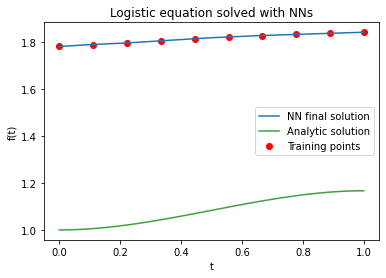

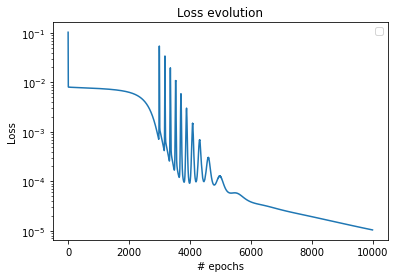

In [ ]:
#df
run_model(lr=0.1, m_epochs=10_000)

In [ ]:
df_ = torch.tensor([[0.0000, 0.0074],
        [0.0074, 0.0908],
        [0.0908, 0.1667],
        [0.1667, 0.2239],
        [0.2239, 0.2537],
        [0.2537, 0.2524],
        [0.2524, 0.2212],
        [0.2212, 0.1652],
        [0.1652, 0.0917],
        [0.0917, 0.0088]], requires_grad=True) 
f_ =torch.tensor([1.0000, 1.0988, 1.2716, 1.4938, 1.7407, 1.9877, 2.2099, 2.3827, 2.4815,
        2.4815], requires_grad=True).reshape(-1,1) 
df_.shape, f_.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [ ]:
df_ = torch.tensor([[0., -0.0003],
        [ -0.0003, 0.0949],
        [ 0.0949, 0.1712],
        [ 0.1712, 0.2233],
        [ 0.2233, 0.2487],
        [ 0.2487, 0.2471],
        [ 0.2471,0.2193],
        [ 0.2193, 0.1671],
        [ 0.1671, 0.0937],
        [ 0.0937,0.0038]], requires_grad=True) 
f_ =torch.tensor([1.0000, 1.0988, 1.2716, 1.4938, 1.7407, 1.9877, 2.2099, 2.3827, 2.4815, 2.4815], requires_grad=True).reshape(-1,1) 
df_.shape, f_.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [ ]:
df_dummy = torch.tensor([[0., 1.],
        [ 1., 2.],
        [ 2., 3.],
        [ 3., 4.],
        [ 4., 5.],
        [ 5., 6.],
        [ 6.,7.],
        [ 7., 8.],
        [8., 9.],
        [ 9.,10.]], requires_grad=True) 
# df_dummy = torch.tensor([[1.],
#         [2.],
#         [3.],
#         [ 4.],
#         [ 5.],
#         [  6.],
#         [ 7.],
#         [  8.],
#         [9.],
#         [ 10.]], requires_grad=True) 
f_dummy =torch.tensor([2., 4., 6., 8., 10., 12., 14., 16., 18., 20.], requires_grad=True).reshape(-1,1) 
df_dummy.shape, f_dummy.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [ ]:
import torch
import torch.nn as nn

In [ ]:
n_in, n_h, n_out, batch_size = 2, 5, 1, 10

In [ ]:
x = df_
y = f_
x.shape, y.shape, x, y

(torch.Size([10, 2]), torch.Size([10, 1]), tensor([[ 0.0000, -0.0003],
         [-0.0003,  0.0949],
         [ 0.0949,  0.1712],
         [ 0.1712,  0.2233],
         [ 0.2233,  0.2487],
         [ 0.2487,  0.2471],
         [ 0.2471,  0.2193],
         [ 0.2193,  0.1671],
         [ 0.1671,  0.0937],
         [ 0.0937,  0.0038]], requires_grad=True), tensor([[1.0000],
         [1.0988],
         [1.2716],
         [1.4938],
         [1.7407],
         [1.9877],
         [2.2099],
         [2.3827],
         [2.4815],
         [2.4815]], grad_fn=<ReshapeAliasBackward0>))

In [ ]:
x = df_
y = f_
x.shape, y.shape, x, y

(torch.Size([10, 2]), torch.Size([10, 1]), tensor([[ 0.0000, -0.0003],
         [-0.0003,  0.0949],
         [ 0.0949,  0.1712],
         [ 0.1712,  0.2233],
         [ 0.2233,  0.2487],
         [ 0.2487,  0.2471],
         [ 0.2471,  0.2193],
         [ 0.2193,  0.1671],
         [ 0.1671,  0.0937],
         [ 0.0937,  0.0038]], requires_grad=True), tensor([[1.0000],
         [1.0988],
         [1.2716],
         [1.4938],
         [1.7407],
         [1.9877],
         [2.2099],
         [2.3827],
         [2.4815],
         [2.4815]], grad_fn=<ReshapeAliasBackward0>))

In [ ]:
class Model_reg(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.ReLU()):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        f_out = self.layer_out(out)
        return f_out


In [ ]:
model = Model_reg(3,10)

In [ ]:
# model = nn.Sequential(nn.Linear(n_in, n_h),
#                      nn.ReLU(),
#                      nn.Linear(n_h, n_h),
#                       nn.ReLU(),
#                      nn.Linear(n_h, n_out),
#                      nn.ReLU())

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
for epoch in range(2000):
    # Forward Propagation
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%5==0: print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  2.8562042713165283
epoch:  5  loss:  0.31353721022605896
epoch:  10  loss:  0.30069562792778015
epoch:  15  loss:  0.3001353442668915
epoch:  20  loss:  0.2995953857898712
epoch:  25  loss:  0.2990718185901642
epoch:  30  loss:  0.29851651191711426
epoch:  35  loss:  0.29799678921699524
epoch:  40  loss:  0.29748812317848206
epoch:  45  loss:  0.29698285460472107
epoch:  50  loss:  0.2965082824230194
epoch:  55  loss:  0.29610341787338257
epoch:  60  loss:  0.29568666219711304
epoch:  65  loss:  0.2952708303928375
epoch:  70  loss:  0.29484015703201294
epoch:  75  loss:  0.2944086790084839
epoch:  80  loss:  0.29376220703125
epoch:  85  loss:  0.29308706521987915
epoch:  90  loss:  0.29238593578338623
epoch:  95  loss:  0.2916349768638611
epoch:  100  loss:  0.29084113240242004
epoch:  105  loss:  0.29000112414360046
epoch:  110  loss:  0.28932496905326843
epoch:  115  loss:  0.28863996267318726
epoch:  120  loss:  0.287919282913208
epoch:  125  loss:  0.2871604561805

In [ ]:
for epoch in range(2000):
    # Forward Propagation
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%5==0: print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  2.184813976287842
epoch:  5  loss:  0.2943878769874573
epoch:  10  loss:  0.2939926087856293
epoch:  15  loss:  0.29368528723716736
epoch:  20  loss:  0.29336994886398315
epoch:  25  loss:  0.29304563999176025
epoch:  30  loss:  0.2927113473415375
epoch:  35  loss:  0.29236605763435364
epoch:  40  loss:  0.29200682044029236
epoch:  45  loss:  0.2916371822357178
epoch:  50  loss:  0.29125162959098816
epoch:  55  loss:  0.2908514142036438
epoch:  60  loss:  0.2904358506202698
epoch:  65  loss:  0.29000329971313477
epoch:  70  loss:  0.2895520031452179
epoch:  75  loss:  0.28908056020736694
epoch:  80  loss:  0.28858742117881775
epoch:  85  loss:  0.2880712151527405
epoch:  90  loss:  0.2875297963619232
epoch:  95  loss:  0.2869611382484436
epoch:  100  loss:  0.28636521100997925
epoch:  105  loss:  0.2857378423213959
epoch:  110  loss:  0.28507769107818604
epoch:  115  loss:  0.28438204526901245
epoch:  120  loss:  0.28364843130111694
epoch:  125  loss:  0.2828741371631

In [ ]:
model(x)

tensor([[1.0722],
        [1.0295],
        [1.2727],
        [1.4914],
        [1.7423],
        [1.9910],
        [2.2047],
        [2.3911],
        [2.4755],
        [2.4776]], grad_fn=<AddmmBackward0>)

In [ ]:
for epoch in range(10000):
    # Forward Propagation
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%50==0: print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  0.021226510405540466
epoch:  10  loss:  0.02125454694032669
epoch:  20  loss:  0.02114863321185112
epoch:  30  loss:  0.021126769483089447
epoch:  40  loss:  0.021153753623366356
epoch:  50  loss:  0.021102532744407654
epoch:  60  loss:  0.02109234407544136
epoch:  70  loss:  0.020982002839446068
epoch:  80  loss:  0.02090548165142536
epoch:  90  loss:  0.02103772945702076
epoch:  100  loss:  0.020855775102972984
epoch:  110  loss:  0.020826829597353935
epoch:  120  loss:  0.020872395485639572
epoch:  130  loss:  0.021033797413110733
epoch:  140  loss:  0.020854134112596512
epoch:  150  loss:  0.021091705188155174
epoch:  160  loss:  0.02108224481344223
epoch:  170  loss:  0.02063611149787903
epoch:  180  loss:  0.020848998799920082
epoch:  190  loss:  0.020660318434238434
epoch:  200  loss:  0.020629767328500748
epoch:  210  loss:  0.020814096555113792
epoch:  220  loss:  0.020586121827363968
epoch:  230  loss:  0.02048405073583126
epoch:  240  loss:  0.0206729825586

In [ ]:
for epoch in range(10000):
    # Forward Propagation
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%50==0: print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  3.5913352966308594
epoch:  50  loss:  3.5913352966308594
epoch:  100  loss:  3.5913352966308594
epoch:  150  loss:  3.5913352966308594
epoch:  200  loss:  3.5913352966308594
epoch:  250  loss:  3.5913352966308594
epoch:  300  loss:  3.5913352966308594
epoch:  350  loss:  3.5913352966308594
epoch:  400  loss:  3.5913352966308594
epoch:  450  loss:  3.5913352966308594
epoch:  500  loss:  3.5913352966308594
epoch:  550  loss:  3.5913352966308594
epoch:  600  loss:  3.5913352966308594
epoch:  650  loss:  3.5913352966308594
epoch:  700  loss:  3.5913352966308594
epoch:  750  loss:  3.5913352966308594
epoch:  800  loss:  3.5913352966308594
epoch:  850  loss:  3.5913352966308594
epoch:  900  loss:  3.5913352966308594
epoch:  950  loss:  3.5913352966308594
epoch:  1000  loss:  3.5913352966308594
epoch:  1050  loss:  3.5913352966308594
epoch:  1100  loss:  3.5913352966308594
epoch:  1150  loss:  3.5913352966308594
epoch:  1200  loss:  3.5913352966308594
epoch:  1250  loss:  3.

In [ ]:
for epoch in range(500):
    # Forward Propagation
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%10==0: print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  3.5913352966308594
epoch:  10  loss:  3.5913352966308594
epoch:  20  loss:  3.5913352966308594
epoch:  30  loss:  3.5913352966308594
epoch:  40  loss:  3.5913352966308594
epoch:  50  loss:  3.5913352966308594
epoch:  60  loss:  3.5913352966308594
epoch:  70  loss:  3.5913352966308594
epoch:  80  loss:  3.5913352966308594
epoch:  90  loss:  3.5913352966308594
epoch:  100  loss:  3.5913352966308594
epoch:  110  loss:  3.5913352966308594
epoch:  120  loss:  3.5913352966308594
epoch:  130  loss:  3.5913352966308594
epoch:  140  loss:  3.5913352966308594
epoch:  150  loss:  3.5913352966308594
epoch:  160  loss:  3.5913352966308594
epoch:  170  loss:  3.5913352966308594
epoch:  180  loss:  3.5913352966308594
epoch:  190  loss:  3.5913352966308594
epoch:  200  loss:  3.5913352966308594
epoch:  210  loss:  3.5913352966308594
epoch:  220  loss:  3.5913352966308594
epoch:  230  loss:  3.5913352966308594
epoch:  240  loss:  3.5913352966308594
epoch:  250  loss:  3.59133529663085

In [ ]:
model(df_), f_

(tensor([[1.1348],
         [1.0013],
         [1.2569],
         [1.4926],
         [1.7655],
         [1.9839],
         [2.2147],
         [2.4019],
         [2.4855],
         [2.4500]], grad_fn=<ReluBackward0>), tensor([[1.0000],
         [1.0988],
         [1.2716],
         [1.4938],
         [1.7407],
         [1.9877],
         [2.2099],
         [2.3827],
         [2.4815],
         [2.4815]], grad_fn=<ReshapeAliasBackward0>))